In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import *
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF

from run_id import run_id
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

wos_all


In [2]:
docs = Doc.objects.filter(query=q)

js = docs.filter(journal__isnull=False).values('journal__id','journal__fulltext').annotate(
    n = Count('id')
)
top_js = js.order_by('-n')[:10]

In [3]:
jys = docs.filter(journal__in=top_js.values_list('journal_id',flat=True)).values('PY','journal__fulltext').annotate(
    n = Count('id')
)
df = pd.DataFrame.from_dict(list(jys))
df.head()

,PY,journal__fulltext,n
0,1991,GEOPHYSICAL RESEARCH LETTERS,8
1,1981,NATURE,9
2,2003,JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES,72
3,1985,CLIMATIC CHANGE,21
4,2002,SCIENCE,40


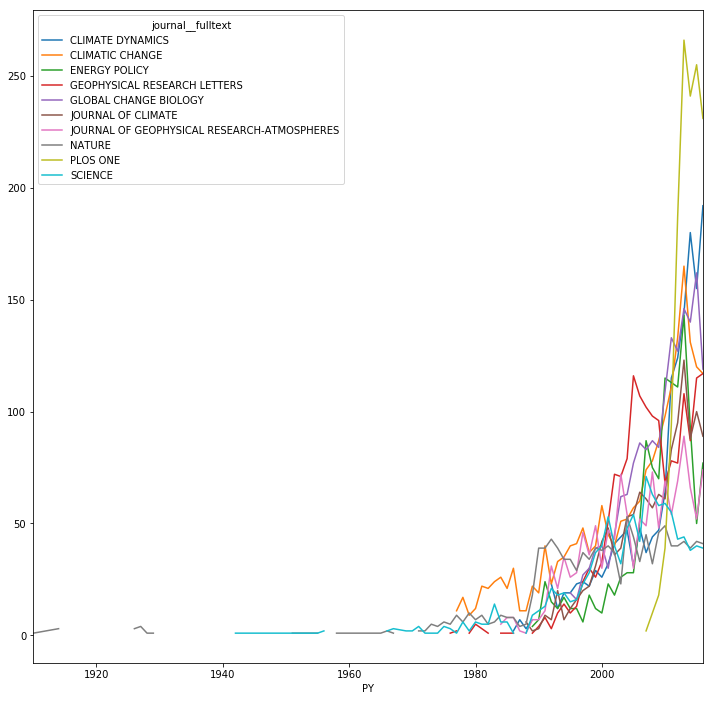

In [4]:
plt.rcParams["figure.figsize"] = [12,12]

pdf = df.pivot('PY','journal__fulltext','n')
pdf.head()

pdf.plot()

plt.show()

In [12]:
cjys = docs.filter(journal__in=top_js.values_list('journal_id',flat=True)).values('PY','journal__fulltext').annotate(
    n = Sum('wosarticle__tc')
)
df = pd.DataFrame.from_dict(list(cjys))
df.head()

,PY,journal__fulltext,n
0,1991,GEOPHYSICAL RESEARCH LETTERS,728
1,1981,NATURE,187
2,2003,JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES,4277
3,1985,CLIMATIC CHANGE,887
4,2002,SCIENCE,5739


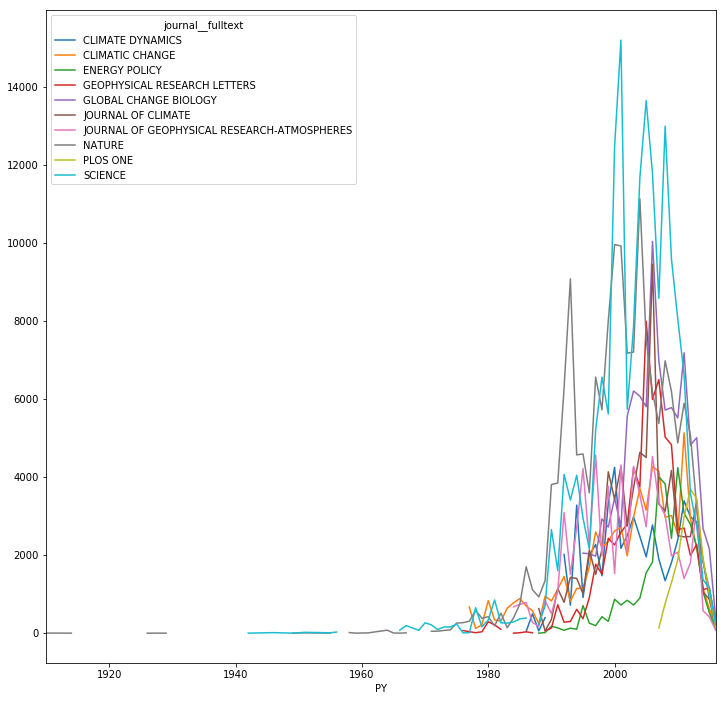

In [13]:
plt.rcParams["figure.figsize"] = [12,12]

pdf = df.pivot('PY','journal__fulltext','n')
pdf.head()

pdf.plot()

plt.show()

In [5]:
njournals = JournalAbbrev.objects.filter(doc__query=q).values('doc__PY').annotate(
    n = Count('id')
).order_by('doc__PY')
jdf = pd.DataFrame.from_dict(list(njournals))
#jdf = jdf.set_index('doc__PY')
jdf.head()

,doc__PY,n
0,1900,1
1,1903,1
2,1907,1
3,1910,1
4,1913,1


118315


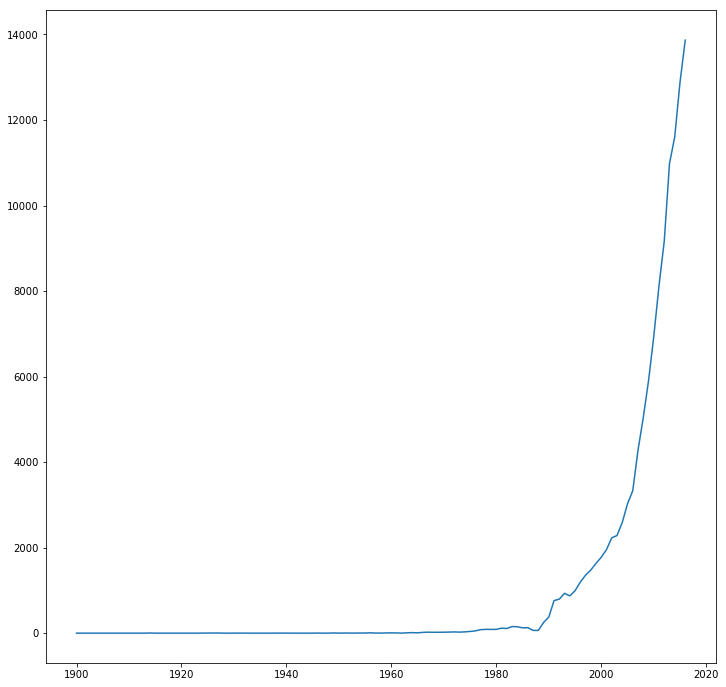

,doc__PY,n
0,1900,1
1,1903,1
2,1907,1
3,1910,1
4,1913,1


In [6]:
print(jdf['n'].sum())
plt.plot(jdf['doc__PY'],jdf['n'])
plt.show()
jdf.head()

In [7]:
for j in top_js:
    print(j['journal__fulltext'])
    print(j['n'])
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dthreshold
    )
    tops = dts.values('topic').annotate(
        t = Sum('score')
    )
    print(tops.values('topic__title','t').order_by('-t')[:10])

CLIMATIC CHANGE
2071
<QuerySet [{'topic__title': '{climat, chang, respons}', 't': 6.57175291438905}, {'topic__title': '{scenario, futur, simul}', 't': 3.80954199382068}, {'topic__title': '{adapt, vulner, strategi}', 't': 3.77689948835457}, {'topic__title': '{model, simul, predict}', 't': 3.46684809290746}, {'topic__title': '{project, uncertainti, futur}', 't': 3.28255568967895}, {'topic__title': '{temperatur, air, mean}', 't': 3.18578744985779}, {'topic__title': '{research, sustain, manag}', 't': 3.13984940737245}, {'topic__title': '{extrem, event, weather}', 't': 2.82024069900103}, {'topic__title': '{precipit, annual, moistur}', 't': 2.71870894981391}, {'topic__title': '{region, china, area}', 't': 2.62660797928368}]>
GLOBAL CHANGE BIOLOGY
1726
<QuerySet [{'topic__title': '{soil, moistur, respir}', 't': 6.06992832065323}, {'topic__title': '{speci, distribut, rang}', 't': 4.96197459298272}, {'topic__title': '{ecosystem, servic, function}', 't': 4.94599180270274}, {'topic__title': '{ele

In [8]:
HJs = js.order_by('-n')[:30]

for j in HJs:
    print(j['journal__fulltext'])
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dthreshold
    )
    H = 0
    ts = dts.values('topic').annotate(
        pzc = Sum('score')
    )
    for t in ts:
        H+=t['pzc']*np.log(t['pzc'])
    H = -1*H
    j['H'] = H
    print(round(H))

CLIMATIC CHANGE
-70.0
GLOBAL CHANGE BIOLOGY
-118.0
GEOPHYSICAL RESEARCH LETTERS
-88.0
CLIMATE DYNAMICS
-126.0
PLOS ONE
-31.0
JOURNAL OF CLIMATE
-99.0
JOURNAL OF GEOPHYSICAL RESEARCH-ATMOSPHERES
-60.0
ENERGY POLICY
-89.0
NATURE
17.0
SCIENCE
24.0
GLOBAL AND PLANETARY CHANGE
-4.0
INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL
-22.0
ENVIRONMENTAL SCIENCE & TECHNOLOGY
16.0
PALAEOGEOGRAPHY PALAEOCLIMATOLOGY PALAEOECOLOGY
-11.0
PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA
25.0
QUATERNARY SCIENCE REVIEWS
-16.0
JOURNAL OF CLEANER PRODUCTION
-12.0
ENERGY
-20.0
APPLIED ENERGY
-8.0
FOREST ECOLOGY AND MANAGEMENT
-14.0
RENEWABLE & SUSTAINABLE ENERGY REVIEWS
-16.0
INTERNATIONAL JOURNAL OF CLIMATOLOGY
-6.0
ABSTRACTS OF PAPERS OF THE AMERICAN CHEMICAL SOCIETY
0
SCIENCE OF THE TOTAL ENVIRONMENT
24.0
BIOGEOSCIENCES
13.0
ENVIRONMENTAL RESEARCH LETTERS
25.0
JOURNAL OF HYDROLOGY
-0.0
QUATERNARY INTERNATIONAL
9.0
GLOBAL BIOGEOCHEMICAL CYCLES
9.0
SOIL BIOLOGY & BIOCHEMISTRY

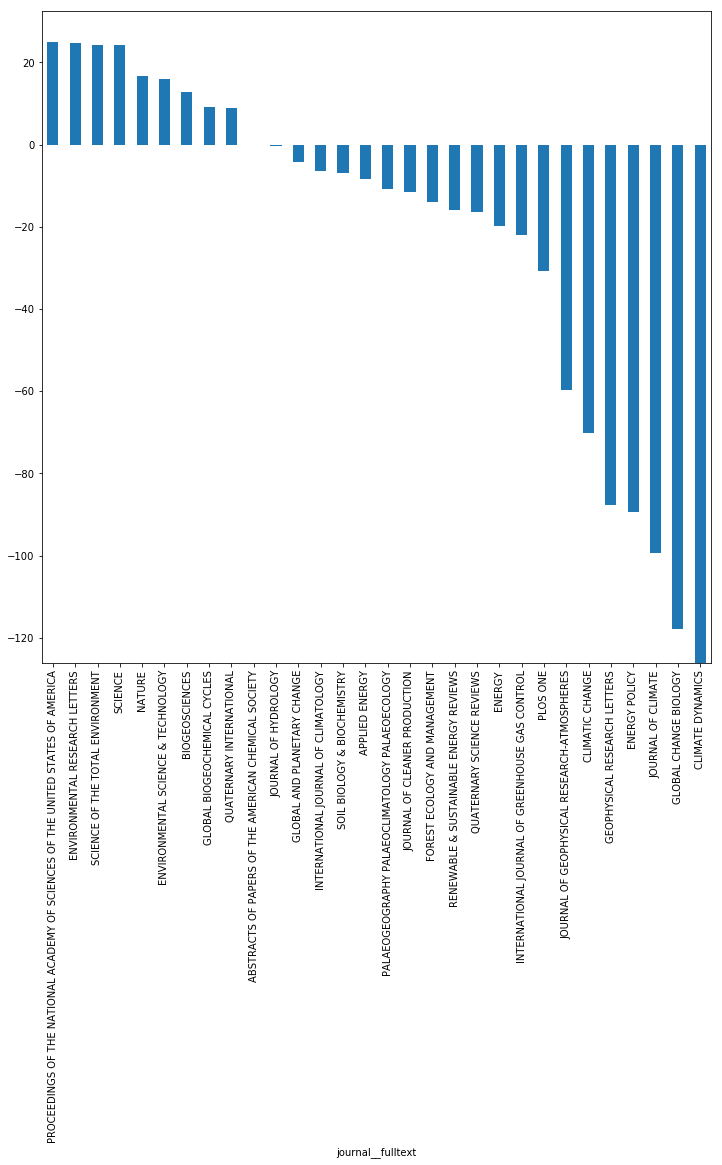

In [9]:
df = pd.DataFrame.from_dict(list(HJs)).sort_values('H',ascending=False)

df = df.set_index('journal__fulltext')

df.head()

df['H'].plot.bar()

plt.show()

# Entropy
$$ H(z\rvert c,y) = -\sum_{i=1}^{K} \hat{p}(z_i \rvert c,y)  log \hat{p}(z_i \rvert c, y) $$

In [11]:
dts = DocTopic.objects.filter(
    doc__journal__fulltext="NATURE"
)

dts.count()

139095